# Chatbot with message summarization

Trimming and filtering of information might lead to loss of context, which can be detrimental to the performance of a chatbot.
## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
from langgraph.graph import MessagesState


class State(MessagesState):
    # messages is a already defined in the parent class
    summary: str

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

First we will define a node whose task would be use the current question with summarized version of the text if exists

In [10]:
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

next we will define a node that will summarize the text and remove the messages keeping the latest one

In [ ]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
    return {"summary": response.content, "messages": delete_messages}


# what we are doing is we are summarizing the conversation and keeping the latest message and updating the state

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [11]:
from langgraph.graph import END


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

So the objective over is here is :
- To summarize the conversation every time the conversation reaches 6 messages. We will keep the latest message and summarize the conversation.
- We will use Memory to store the all the conversation messages by threading the state through the nodes.


In [12]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

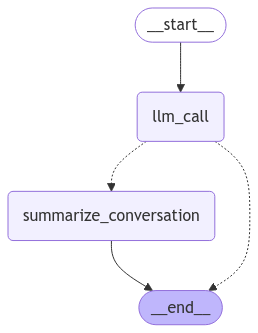

In [13]:
builder = StateGraph(state_schema=State)
# add nodes
builder.add_node("llm_call", call_model)
builder.add_node("summarize_conversation", summarize_conversation)
# add edges
builder.add_edge(START, "llm_call")
builder.add_conditional_edges(source="llm_call", path=should_continue)
builder.add_edge("summarize_conversation", END)

# compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Create a thread
from uuid import uuid4

config = {"configurable": {"thread_id": str(uuid4())}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you particularly enjoyed?


In [15]:
# still no summary as we have not reached the limit
graph.get_state(config).values.get("summary","")

''

In [16]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, as of September 2023, Nick Bosa became the highest-paid defensive player in NFL history. He signed a five-year contract extension with the San Francisco 49ers worth $170 million, with $122.5 million guaranteed. Bosa is known for his exceptional skills as a defensive end and has been a key player for the 49ers.


In [17]:
graph.get_state(config).values.get("summary","")

'Lance introduced himself and mentioned that he is a fan of the San Francisco 49ers. He expressed a particular liking for Nick Bosa, and it was confirmed that Bosa became the highest-paid defensive player in NFL history as of September 2023, with a significant contract extension with the 49ers.'